# $\sigma^0$ from GEE + normalization

This code is a semi-automatic routine for the download of values of $\sigma^0$ from Sentinel-1 via the Google Earth Engine API. The downloaded data represent the mean value of $\sigma^0$ over the AoI, that must be provided manually into the code as a Java polygon or similar object; the variance of the data is provided as well.

---
**Dependencies** 

This code requires the installation of the Earth Engine API, `ee`. You can find more info on the installation procedure here: [Python installation of GEE](https://developers.google.com/earth-engine/guides/python_install). \
This code runs on browser-based notebooks only (Google Colaboratory, Jupyter Notebooks, etc...). \
Be aware that you won't need to install the Google Cloud APK to run the code. 

---
**Normalization of $\sigma^0$ data for different orbits**

After download, $\sigma^0$ values are normalized with respect to orbits. The chosen approach is based on the normalization of the values' distributions of different orbits on a reference distribution (Mladenova, 2013, DOI: 10.1109/TGRS.2012.2205264). The orbit that is chosen as reference by default is the one which average incidence angle is the closest to 40°.

---
**Output**

The output database has columns:
- Date: timestamp of date and time of passage rounded at hour
- Angle[°]: angle of incidence
- Geometry: name of AoI
- Orb: orbit relative number
- Pass: direction of passage, ascending or descending
- VV[dB], VH[dB]: mean values of $\sigma^0$, not normalized
- VV_var[dB], VH_var[dB]: variance of values of $\sigma^0$
- VV_norm[dB], VH_norm[dB]: mean values of $\sigma^0$, normalized

In [1]:
import sys
sys.path.append('../')
from modules.funcs_gee import *

In [2]:
# Trigger the authentication flow.
ee.Authenticate()
 
# Initialize the library.
ee.Initialize()

Enter verification code:  4/1AWgavddalm7D06vKSWwhyzlyQfW-PtxvlqcABWBaahKztXBL5ThLrl3OtRM



Successfully saved authorization token.


In [15]:
# Filters definition
# fil_orb95   = ee.Filter.eq('relativeOrbitNumber_start', 95)
# fil_orb168  = ee.Filter.eq('relativeOrbitNumber_start', 168)
# fil_orb117 = ee.Filter.eq('relativeOrbitNumber_start', 117)

sp17 = ee.Filter.date('2017-04-04', '2017-05-22') # related to Budrio field
su17 = ee.Filter.date('2017-05-22', '2017-09-15') # related to Budrio field
au17 = ee.Filter.date('2017-09-15', '2017-11-02') # related to Budrio field

# missing data on 2016-10-01 raises not-exceptable exception
# tot = ee.Filter.date('2014-10-03', '2022-12-01')

tot1 = ee.Filter.date('2014-10-03', '2016-09-30')
tot2 = ee.Filter.date('2016-10-02', '2022-12-01')

In [16]:
# Define area of interest
# If you have a GeoJSON file, copy paste.
# If you have a KML, export to GeoJSON (plenty of free tools online)
# or retrieve P

geoJSON = {
"type": "FeatureCollection",
"name": "merged",
"crs": { "type": "name", "properties": { "name": "urn:ogc:def:crs:OGC:1.3:CRS84" } },
"features": [
{ "type": "Feature", "properties": { "Name": "Budrio_campo_right", "description": None, "tessellate": 1 }, "geometry": { "type": "Polygon", "coordinates": [ [ [ 11.533083525108189, 44.570697786985733 ], [ 11.532456431504921, 44.569896556005418 ], [ 11.53276321111148, 44.569791821233608 ], [ 11.53338591526418, 44.570601794304793 ], [ 11.533083525108189, 44.570697786985733 ] ] ] } },
{ "type": "Feature", "properties": { "Name": "Budrio_campo_safe_half", "description": None, "tessellate": 1 }, "geometry": { "type": "Polygon", "coordinates": [ [ [ 11.53262979564736, 44.570842547510622 ], [ 11.532328100248961, 44.570445732016537 ], [ 11.53264162483709, 44.570339694294631 ], [ 11.532950828277439, 44.570738040751841 ], [ 11.53262979564736, 44.570842547510622 ] ] ] } }
]
}

nfeatures = len(geoJSON['features'])
coords = [geoJSON['features'][i]['geometry']['coordinates'] for i in range(nfeatures)]
aoi = ee.Geometry.MultiPolygon(coords)

geometry_title = input('Please provide a title for AoI geometry. (Default: Budrio_half-right)')
if not geometry_title: geometry_title='Budrio_half-right'

Please provide a title for AoI geometry. (Default: Budrio_half-right) 


In [17]:
# Get collection of images and filter
img1 = (ee.ImageCollection('COPERNICUS/S1_GRD_FLOAT') # linear scale for mean, var computation
        .filterBounds(aoi)
        .filter(tot1)
        .sort('system:time_start'))
img2 = (ee.ImageCollection('COPERNICUS/S1_GRD_FLOAT') # linear scale for mean, var computation
        .filterBounds(aoi)
        .filter(tot2)
        .sort('system:time_start'))

# acq_times = img.aggregate_array('system:time_start').getInfo()
# len([time.strftime('%x', time.gmtime(acq_time/1000)) for acq_time in acq_times])

In [18]:
def extract_data(image:ee.Image):
    """Ausiliary function to extract data from an Image
    
    This function extracts spatial means and std.dev
    via spatial reducers (reduceRegion).
    Optimal implementation is to map this function
    on a whole ImageCollection via .map() and insert the
    return into a ee.FeatureCollection.
    
    Return
    ------
    ee.Feature
    
    """
    
    mean = image.reduceRegion(**{ 
        'reducer': ee.Reducer.mean(),
        'geometry': aoi,
    })
    
    dev = image.reduceRegion(**{ 
        'reducer': ee.Reducer.stdDev(),
        'geometry': aoi,
    })
    
    var = image.reduceRegion(**{
        'reducer':ee.Reducer.variance(),
        'geometry': aoi,
    })

    properties = {
        'Date': image.get('system:time_start'), # only way to get a timestr is an external operation
        'Geometry': geometry_title,
        'VV[lin]': mean.get('VV'),
        'VH[lin]': mean.get('VH'),
        'Angle[°]': mean.get('angle'),
        'VV_var[lin]': var.get('VV'),
        'VH_var[lin]': var.get('VH'),
        'Orb': image.get('relativeOrbitNumber_start'),
        'Pass': image.get('orbitProperties_pass'),
    }
            
            
    return ee.Feature(None, properties)

In [19]:
def clean_date(date:int):
    return time.strftime('%x %H', time.localtime((date)/1000))

dflist = []
for img in [img1, img2]:
    data = ee.FeatureCollection(img.map(extract_data))
    data_out = data.getInfo()
    data_out_to_df = [e.get('properties') for e in data_out.get('features')]; data_out_to_df[0]
    df = pd.DataFrame.from_dict(data_out_to_df)
    df.Date = df.Date.apply(lambda x : pd.to_datetime(clean_date(x)))
    df['VV[dB]'] = df['VV[lin]'].apply(lambda x : lin_db(x))
    df['VH[dB]'] = df['VH[lin]'].apply(lambda x : lin_db(x))
    df['VV_var[dB]'] = df['VV_var[lin]']/df['VV[lin]']*(10/np.log(10))
    df['VH_var[dB]'] = df['VH_var[lin]']/df['VH[lin]']*(10/np.log(10))
    dflist.append(df)

dftot = pd.concat([dflist[0],dflist[1]]).set_index('Date'); dftot

,Angle[°],Geometry,Orb,Pass,VH[lin],VH_var[lin],VV[lin],VV_var[lin],VV[dB],VH[dB],VV_var[dB],VH_var[dB]
Date,,,,,,,,,,,,
2014-10-12 07:00:00,41.268929,Budrio_half-right,95,DESCENDING,0.019403,0.000044,0.165803,0.004212,-7.804083,-17.121268,0.110340,0.009797
2014-10-12 07:00:00,41.268929,Budrio_half-right,95,DESCENDING,0.019403,0.000044,0.165803,0.004212,-7.804083,-17.121268,0.110340,0.009797
2014-10-24 07:00:00,41.271503,Budrio_half-right,95,DESCENDING,0.006721,0.000008,0.081771,0.000852,-10.874000,-21.725451,0.045247,0.005138
2014-11-17 06:00:00,41.107655,Budrio_half-right,95,DESCENDING,0.022583,0.000047,0.180793,0.003206,-7.428182,-16.462105,0.077004,0.009036
2014-11-29 06:00:00,41.106918,Budrio_half-right,95,DESCENDING,0.020082,0.000070,0.190233,0.004016,-7.207139,-16.972004,0.091675,0.015033
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-12 18:00:00,37.399632,Budrio_half-right,117,ASCENDING,0.008295,0.000025,0.062336,0.000590,-12.052590,-20.812039,0.041081,0.013176
2022-11-16 06:00:00,31.267229,Budrio_half-right,168,DESCENDING,0.024676,0.000096,0.215107,0.006513,-6.673451,-16.077300,0.131493,0.016926
2022-11-23 06:00:00,41.307030,Budrio_half-right,95,DESCENDING,0.026612,0.000089,0.244474,0.006738,-6.117674,-15.749171,0.119698,0.014454


# Backscattering normalization

Ref: DOI: 10.1109/tgrs.2012.2205264, https://ieeexplore.ieee.org/document/6264094 (Mladenova (2013))

In [20]:
import warnings

# need orbits in databaes: exploit sets' uniquity
orb_list = [*set(dftot.Orb.values)]

n=0
leng_list=[]
for orb in orb_list:
    leng = len(dftot[dftot.Orb==orb]) 
    print(f'orbit {orb} has {leng} data')
    if leng==1:
        warnings.warn(f'\nOrbit {orb} has only 1 datum. '+
                      'This orbit will be ignored.')
    leng_list.append(leng)
    n+=leng
print(f'total number of data is {n}')

bad_orb_list=[orb_list[i] for i in range(len(orb_list)) if leng_list[i]==1]
orb_list=[orb_list[i] for i in range(len(orb_list)) if leng_list[i]>1]; orb_list

for bad in bad_orb_list:
    dftot=dftot.drop(dftot[dftot.Orb==bad].index)

orbit 168 has 384 data
orbit 117 has 382 data
orbit 95 has 385 data
total number of data is 1151


In [21]:
normdict = dict()
nnormdict = dict()

for orb in orb_list:
    d = dict()
    for pol in ['VV','VH']:
        d[f'{pol}']      = dftot.loc[dftot.Orb==orb][f'{pol}[dB]'].values
        d[f'{pol}_mean'] = np.mean(dftot.loc[dftot.Orb==orb][f'{pol}[dB]'].values)
        d[f'{pol}_std']  = np.std(dftot.loc[dftot.Orb==orb][f'{pol}[dB]'].values)
        if d[f'{pol}_std']==0: d[f'{pol}_std']=np.sqrt(abs(d[f'{pol}_mean']))
        d[f'angle_mean'] = np.mean(dftot.loc[dftot.Orb==orb][f'Angle[°]'].values)
    d['angle'] = dftot.loc[dftot.Orb==orb][f'Angle[°]'].values
    normdict[orb] = d
    
normdf = pd.DataFrame.from_dict(normdict, orient='index'); normdf
statsnorm = normdf.drop(columns=['VV','VH','angle']); statsnorm

,VV_mean,VV_std,angle_mean,VH_mean,VH_std
168,-8.059031,2.820688,31.331243,-18.192002,3.415233
117,-10.231410,2.796976,37.400273,-18.727557,3.298258
95,-9.738871,2.563697,41.278750,-19.084662,3.286345


In [22]:
# Find orbit that has mean angle nearest to 40°
# and choose it as reference statistics
orb_ref = normdf.angle_mean.apply(lambda x : abs(x-40)).sort_values().head(1).index.values[0]
if not input(f'The orbit with mean incidence angle nearest to 40° is orbit {orb_ref}. '+
             'This orbit will be taken as reference orbit for normalization. Proceed? [[]/any]')=='':
    raise NameError('Manually set orb_ref variable with chosen reference orbit (type:int).')
else: print(f'\nOrbit {orb_ref} has been set as reference orbit.')

for orb in orb_list:
    d = dict()
    for pol in ['VV', 'VH']:
        d[f'{pol}']      = HIST_norm(
            normdf.loc[orb_ref][f'{pol}_mean'],
            normdf.loc[orb_ref][f'{pol}_std'],
            [
                normdf.loc[orb][pol],
                normdf.loc[orb][f'{pol}_mean'],
                normdf.loc[orb][f'{pol}_std'],
            ]
                 )
        d[f'{pol}_mean'] = np.mean(d[f'{pol}'])
        d[f'{pol}_std']  = np.std(d[f'{pol}'])
    nnormdict[orb] = d
    
nnormdf = pd.DataFrame.from_dict(nnormdict, orient='index')

dftot['VV_norm[dB]']= dftot.apply( 
    lambda x :
    HIST_norm(
        statsnorm['VV_mean'][orb_ref],
        statsnorm['VV_std'][orb_ref],
        [   
            x['VV[dB]'],    
            statsnorm['VV_mean'][x.Orb],    
            statsnorm['VV_std'][x.Orb]
        ],   
    ),
    axis='columns',
)

dftot['VH_norm[dB]']= dftot.apply( 
    lambda x :
    HIST_norm(
        statsnorm['VH_mean'][orb_ref],
        statsnorm['VH_std'][orb_ref],
        [   
            x['VH[dB]'],    
            statsnorm['VH_mean'][x.Orb],    
            statsnorm['VH_std'][x.Orb]
        ],   
    ),
    axis='columns',
)

dftot=dftot.drop(['VH[lin]','VH_var[lin]','VV[lin]','VV_var[lin]',
                 'VV[dB]','VH[dB]','VV_var[dB]','VH_var[dB]'], axis=1)
print('This cell includes a duplicates drop from the dataframe, so you may see a change in the number of values of the dataframe after performing it.')
dftot.drop_duplicates(inplace=True)
dftot.dropna(inplace=True)
dftot

The orbit with mean incidence angle nearest to 40° is orbit 95. This orbit will be taken as reference orbit for normalization. Proceed? [[]/any] 



Orbit 95 has been set as reference orbit.
This cell includes a duplicates drop from the dataframe, so you may see a change in the number of values of the dataframe after performing it.


,Angle[°],Geometry,Orb,Pass,VV_norm[dB],VH_norm[dB]
Date,,,,,,
2014-10-12 07:00:00,41.268929,Budrio_half-right,95,DESCENDING,-7.804083,-17.121268
2014-10-24 07:00:00,41.271503,Budrio_half-right,95,DESCENDING,-10.874000,-21.725451
2014-11-17 06:00:00,41.107655,Budrio_half-right,95,DESCENDING,-7.428182,-16.462105
2014-11-29 06:00:00,41.106918,Budrio_half-right,95,DESCENDING,-7.207139,-16.972004
2014-12-23 06:00:00,41.107285,Budrio_half-right,95,DESCENDING,-9.750607,-18.082929
...,...,...,...,...,...,...
2022-11-12 18:00:00,37.399632,Budrio_half-right,117,ASCENDING,-11.408157,-21.161616
2022-11-16 06:00:00,31.267229,Budrio_half-right,168,DESCENDING,-8.479531,-17.049766
2022-11-23 06:00:00,41.307030,Budrio_half-right,95,DESCENDING,-6.117674,-15.749171


In [23]:
opt_save_df = input('Save df? [y/n]')
if opt_save_df=='y':
    filename = input('Provide filename without extension (def. .csv): [default:geometry name] ')
    if filename=='': filename = geometry_title 
    dftot.to_csv(f'..\Data\{filename}.csv', sep = '\t')

Save df? [y/n] y
Provide filename without extension (def. .csv): [default:geometry name]  


# Snippets

## Plots

In [12]:
def hist_gauss_fit(data, nbins, hist_kwargs, fitline_kwargs,
                   title, density=True, opt_save=False, opt_name='hist_fit',
                  ):
    
    def gauss(x, A, mean, dev):
        """Not-normalized, shifted gaussian distribution."""
        import math
        return A*(1/(dev*np.sqrt(2*math.pi)))*np.exp(-(x-mean)**2/(2*dev**2))

    counts, bins, pads = plt.hist(data, bins=nbins, density=True, **hist_kwargs)
    fit_bounds = [ [0,min(bins),0], [sum(counts)*np.diff(bins)[0],max(bins),abs(max(bins)-min(bins))] ]
    popt, pcov = curve_fit(gauss, bins[:-1], counts, method='trf',bounds=fit_bounds, maxfev=1000)
    A, mean, dev = popt[0], popt[1], popt[2]
    x = np.linspace(min(data), max(data), 50)
    fit = gauss(x, A, mean, dev)
    plt.plot(x, fit, **fitline_kwargs)
    ylabel = 'Density' if density else 'Counts';    plt.ylabel(ylabel)
    plt.legend(loc='best')
    plt.title(title)
    if opt_save: plt.savefig(opt_name+'.png', dpi=300)
    return counts, bins, pads

Save plots? [y/n] n


NameError: name 'bins' is not defined

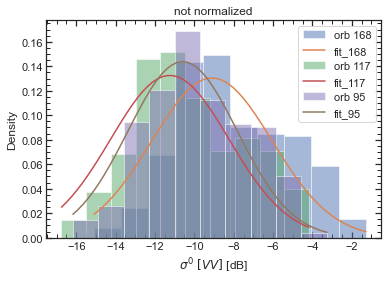

In [13]:
# Histograms plots

opt_save=True if input('Save plots? [y/n]')=='y' else False

normdf.dropna(inplace=True)
nnormdf.dropna(inplace=True)

# Not normalized
plt.figure()
for orb in orb_list:
    hist_kwargs={'alpha':.5, 'label':f'orb {orb}'}
    fitline_kwargs={'linestyle':'-', 'label':f'fit_{orb}'}
    data = normdf['VV'][orb]
    hist_gauss_fit(data, nbins=10, hist_kwargs=hist_kwargs, fitline_kwargs=fitline_kwargs,
                   title='not normalized', density=True, opt_save=opt_save, opt_name='hist_2014-22_fit_not-norm',)
    plt.xlabel(r'$\sigma^0\ [VV]$ [dB]')
t = plt.text(np.min(bins)+1, 0.9*np.max(counts),
             f'# entries: {len(dftot.index)}',
             ha="center", va="center", size=15,
             bbox=dict(boxstyle="round,pad=0.3", fc="tab:orange", ec="k", lw=2, alpha=.5))

# Normalized
plt.figure()
for orb in orb_list:
    hist_kwargs={'alpha':.5, 'label':f'orb {orb}'}
    fitline_kwargs={'linestyle':'-', 'label':f'fit_{orb}'}
    data = nnormdf['VV'][orb]
    counts, bins, pads = hist_gauss_fit(data, nbins=10,
                                        hist_kwargs=hist_kwargs,
                                        fitline_kwargs=fitline_kwargs,
                                        title='normalized', density=True,
                                        opt_save=opt_save, opt_name='hist_2014-22_fit_norm',)
    plt.xlabel(r'$\sigma^0\ [VV]$ [dB]')

t = plt.text(np.min(bins)+1, 0.9*np.max(counts),
             f'# entries: {len(dftot.index)}',
             ha="center", va="center", size=15,
             bbox=dict(boxstyle="round,pad=0.3", fc="tab:orange", ec="k", lw=2, alpha=.5))

In [ ]:
# Timeseries, before normalization

plot_name = 'sigma_norm_2014-22_'
opt_save = True if input('Save plot? [y/n]')=='y' else False
plt.figure(figsize=(20,5))

for orb in orb_list:
    plt.plot(dftot[dftot.Orb==orb]['VV[dB]'], alpha=.5, marker='o', linestyle='-', label=f'orb {orb}')
plt.ylabel(r'$\sigma^0$ [dB]')
plt.xlabel('index')
plt.legend(loc='best')
plt.title('not normalized')
if opt_save: plt.savefig(plot_name+'plot_not-norm.png', dpi=300)
plt.show()

In [ ]:
# Timeseries, after normalization

plot_name = 'sigma_norm_2014-22_'
opt_save = True if input('Save plot? [y/n]')=='y' else False

plt.figure(figsize=(20,5))
for orb in orb_list:
    plt.plot(dftot[dftot.Orb==orb].index, dftot[dftot.Orb==orb]['VV[dB]'], alpha=.5, marker='o', linestyle='-', label=f'orb {orb}')
plt.ylabel(r'$\sigma^0$ [dB]')
plt.xlabel('index')
plt.legend(loc='best')
plt.title('normalized')
if opt_save: plt.savefig(plot_name+'plot_norm.png', dpi=300)
plt.show()